# Cylinder fitting with RANSAC

Last time we fitted a sphere with RANSAC. Now consider fitting a right circular cylinder to given points. Coordinates of the points are stored in [file](./dat/cyl.dat)  `dat\cyl.dat`.

The most difficult problem here is to find the parameters of the cylinder(s) passing through a given set of 5 points. It can be shown that 4 points are not enough, but for 5 points there are even number (0, 2, 4, 6) of solutions. 

Our solution follows the [paper](http://www.heldermann-verlag.de/jgg/jgg10/j10h2zsom.pdf)  by Paul Zsombor-Murray, Sawsan El Fashny (2006). Unfortunately two formulas in the paper have typos, hence we had the task to find and correct them. Fortunately by using the published numerical example 2.1 of the paper and by a computer algebra system we were successful to manage it. One such formula is the second equation under number (5), where the second term is $p_1^2a_2^2$ instead of $p_1a_2^2$. The second typo we found in the coefficient of $d_5$ in equation (10). The third term of the equation of the coefficient should be $-b_1c_2$ instead of $-b_1c_1$. The published method is based on the solution of a 6-degree algebraic equation, therefore it is relatively fast. This is important in RANSAC, since this calculation must be repeated many times.

The solution proceeds along the following steps:
* the given set of 5 points is transformed to a special frame
* a sixth-degree polynomial is assembled for one component of the direction vector of the cylinder derived from a basic formula of the points of the cylinder
* the second component is solved from a linear equation

Basic formula of the points of the cylinder:

$$(\mathbf{x}\times\mathbf{a})^2 -2\mathbf{a}^2(\mathbf{x}\cdot\mathbf{a}) = 0 ,$$

where $\mathbf{x}$ denotes the position of an arbitrary point of the cylinder, $\mathbf{a}$ denotes a vector along the axis of the cylinder. Vector $\mathbf{f}$ points from the origin $O$ to a point on the axis of the cylinder and is perpendicular to vector $\mathbf{a}$ ($\mathbf{a}\cdot\mathbf{f}=0$).

One such equation can be written for each given point, but since the origin $O$ of our coordinate frame can be chosen arbitrarily (e.g. it may be identical with the first point), we have only 4 such equations for the 6 unknowns (these are the components of $\mathbf{a}$ and $\mathbf{f}$). The 5th equation is the condition of perpendicularity.

The length of vector $\mathbf{a}$ is arbitrary (can be set to unit, for example,  $\mathbf{a}^2=1$; only its direction is relevant), hence there are only 5 unknowns and 5 equations are enough for the solution. Length of vector $\mathbf{f}$ is the radius of the cylinder.

First we implement in Python the function for calculating parameters of the right circular cylinder from 5 points. Arguments of the function are coordinates of the 5 points, output is a matrix, where the columns contain parameters for each of the solutions: radius $r$ and components of vectors $\mathbf{a}$ and $\mathbf{f}$.

In [1]:
import numpy as np

def cyl5fit(X1,X2,X3,X4,X5):
    ## cyl5fit(X1,...,X5) fit cylinders to points X1..X5
    ## Reference: Paul(2006): A Cylinder of revolution on Five Points

    ## shift to O:
    o=X1-X1
    pt=X2-X1
    qt=X3-X1
    rt=X4-X1
    st=X5-X1

    ## rotation such that OP=x and OQ is in the xy-plane
    ## transformed x
    x = pt/np.linalg.norm(pt)
    ## transformed y
    y = qt-(np.inner(qt,pt))/np.linalg.norm(pt)*x
    y = y/np.linalg.norm(y)
    ## transformed z
    z = np.array([(x[1]*y[2]-x[2]*y[1]),(x[2]*y[0]-x[0]*y[2]),(x[0]*y[1]-x[1]*y[0])])
    R = np.zeros((3,3))
    R[0,:] = x
    R[1,:] = y
    R[2,:] = z
    p = R.dot(pt)
    q = R.dot(qt)
    r = R.dot(rt)
    s = R.dot(st)

    p1=p[0];q1=q[0];q2=q[1];r1=r[0];r2=r[1];r3=r[2]
    s1=s[0];s2=s[1];s3=s[2]

    ## Eq. 11.
    b1=2*q2*r2*(q1-r1); 
    b2=q2*r3*(p1-2*q1)
    b3=q2*r3*(p1-2*r1)
    b4=q2*(r1*(r1-p1)+r2*(r2-q2))+q1*r2*(p1-q1)
    b5=r3*(q2*(q2-2*r2)+q1*(q1-p1));  b6=q2**2*r3
    b7=q1*r3*(q1-p1)
    b8=q2*(r2*(r2-q2)+r3**2)
    b9=q2*(r1*(r1-p1)+r3**2)+q1*r2*(p1-q1)
    ##
    c1=q2*(r2*s3*(r2-q2)+r3*s2*(q2-s2)+r3*s3*(r3-s3))
    c2=q2*r3*s3*(r3-s3)+q1**2*(r3*s2-r2*s3)+p1*(q2*(r3*s1-r1*s3)+q1*(r2*s3-r3*s2))  \
       +q2*(r1**2*s3-r3*s1**2)
    c3=q2*(p1*(s1*r3-s3*r1)-r3*(s1**2+s2**2)+s3*(r1**2+r2**2)) \
       +(r2*s3-r3*s2)*(q1*(p1-q1)-q2**2)
    c4=2*q2*r3*s3*(s2-r2); c5=2*q2*r3*s3*(s1-r1)
    c6=2*q2*(r3*s2*(s1-q1)+r2*s3*(q1-r1))

    ## Eq. 10.
    d1=c1*b2-b6*c6; d2=c6*b7-b2*c2; d3=c1*b7-b6*c2; d4=c1*b1-b8*c6-b6*c5
    d5=c5*b7+c6*b9-b1*c2-b2*c4; d6=c5*b9+c6*b5-b3*c2-b1*c4-b2*c3
    d7=c1*b5-b8*c4-b6*c3; d8=c1*b9-b8*c2-b6*c4; d9=c1*b3-b8*c5
    d10=c5*b5+c6*b4-b3*c4-b1*c3; d11=c1*b4-b8*c3; d12=c5*b4-b3*c3

    ## Eq. 9.
    D1=d1*d2-d3**2; D2=d4*d2+d1*d5-2*d8*d3; D3=d9*d2+d4*d5+d1*d6-2*d7*d3-d8**2
    D4=d9*d5+d4*d6+d1*d10-2*d11*d3-2*d7*d8
    D5=d9*d6+d4*d10+d1*d12-2*d11*d8-d7**2
    D6=d9*d10+d4*d12-2*d11*d7; D7=d9*d12-d11**2

    ## Eq. 8.
    pol6=np.array([D1,D2,D3,D4,D5,D6,D7])
    r6=np.roots(pol6)

    ## real roots
    a2 = r6.real[np.abs(r6.imag)<1e-12]

    ## number of roots
    n = a2.shape[0]
    ## no solution: 
    if n == 0:
        return 0
    
    ## calculate a1
    e1=c1*(b2*a2**2+b1*a2+b3)-(b6*a2+b8)*(c6*a2+c5)
    e2=c1*(b7*a2**3+b9*a2**2+b5*a2+b4)-(b6*a2+b8)*(c2*a2**2+c4*a2+c3)
    a1=-e2/e1
    a = np.vstack((a1,a2,np.ones((1,n))))  
    norma = np.sqrt(a[0,:]**2+a[1,:]**2+a[2,:]**2)
    
    ## calculate vector f from equations (5)
    asq = a1**2+a2**2+1
    ##"f1, f2, f3"
    f1=p1*(1+a2**2)/asq/2
    f2=(q1**2+q2**2+(q1*a2-q2*a1)**2)/2/asq
    f2=(f2-q1*f1)/q2
    f3=-(a1*f1+a2*f2)
    f = np.vstack((f1,f2,f3))
    ## length of vector f is the radius of the cylinder: r=norm(f)
    radius = np.sqrt(f[0,:]**2+f[1,:]**2+f[2,:]**2)

    ## inverse transformation - rotation
    a = (R.T).dot(a)
    f = (R.T).dot(f)
    ## shift vector f
    f = (f.T + X1).T

    return np.vstack((radius,a/norma,f))

It is compulsory to test such a complicated function. Let us check it with data of example 2.1 in the paper Paul Zsombor-Murray, Sawsan El Fashny (2006):

In [2]:
## Paul Zsombor-Murray (2009): A Cylinder of Revolution on Five Points example 2.1
O=np.array([0,0,0]); P=np.array([3,0,0]); Q=np.array([2,2,0]); R=np.array([0,2,4]); S=np.array([2,0,3]); 
cyl=cyl5fit(O,P,Q,R,S)
print("Results of test 1. of cylinder fitting:")
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)
print(cyl)

Results of test 1. of cylinder fitting:
[[ 1.55079  1.52273]
 [ 0.01138 -0.32165]
 [ 0.36146 -0.01544]
 [ 0.93232  0.94673]
 [ 1.49981  1.34481]
 [ 0.36118  0.54156]
 [-0.15834  0.46572]]


We found only vectors $\mathbf{a}$ in the paper and these are not normalized to 1, but the components $a_3$ are set to 1. Therefore recalculate our solution vectors $\mathbf{a}$ such that their 3rd component is 1. The following values are reported in the paper (for us only the 2 real solutions are of interest):
<img src="img/zsm.png" width="400"/>

Transform and print vectors like this:

In [3]:
a = cyl[1:4,:]; an = a/a[2,:]
np.set_printoptions(precision=10)
print("Our solution: ")
print(np.fliplr(an.T))

Our solution: 
[[ 1.            0.3876994216  0.0122101721]
 [ 1.           -0.0163069808 -0.339744343 ]]


We see that our results are identical with those of the example in the paper.

As we have already mentioned the [scikit-image](http://scikit-image.org/) library can be imported with the statement
```python
import skimage.measure as sm
```
or we can import the necessary functions from the `sm.py` module:
```python
import sm
```
and then we can use the function `ransac()`:
```python
sm.ransac(data, model_class, min_samples, residual_threshold) 
```
which has got four required parameters. 
1. data matrix `data(N, D)` where `N` denotes the number and `D` is dimension of data,
2. Python implementation of the class with required member functions `success = estimate(*data)` and `residuals(*data)`,
3. integer `min_samples`, which is the same as $n$.
4. `residual_threshold`, maximum distance (residual) of conform data.

First we create the class which implements our model.

### CylModel Python class

Class `CylModel`, which is used for RANSAC, consists of a simple constructor and two member functions (`estimate` és `residuals`). Member variable `params` is a vector of 7 components that contain parameters of the cylinder.

In [4]:
class CylModel:
    """model for right circular cylinder fitting 
    """

    def __init__(self):
        self.params = np.zeros(7)

    def estimate(self, X):
        """
        cyl5fit(X) fits cylinders to 5 points stored as rows of matrix X
        Reference: Paul(2006): A Cylinder of revolution on Five Points
        Results: parameters stored in a vector of 7 components  
                params: [r,ax,ay,az,fx,fy,fz], where:
                  r: radius of the cylinder
                  ax,ay,az: unit vector of the cylinder's axis
                  fx,fy,fz: coordinates of a point on the axis
        Remark:  When there is no good solution, the function returns False
        """

        ## shift to O:
        o=X[0,:]-X[0,:]
        pt=X[1,:]-X[0,:]
        qt=X[2,:]-X[0,:]
        rt=X[3,:]-X[0,:]
        st=X[4,:]-X[0,:]

        ## rotation such that OP=x and OQ is in the xy-plane
        x = pt/np.linalg.norm(pt)
        y = qt-(np.inner(qt,pt))/np.linalg.norm(pt)*x
        y = y/np.linalg.norm(y)
        z = np.array([(x[1]*y[2]-x[2]*y[1]),(x[2]*y[0]-x[0]*y[2]),(x[0]*y[1]-x[1]*y[0])])
        R = np.zeros((3,3))
        R[0,:] = x; R[1,:] = y; R[2,:] = z
        p = R.dot(pt)
        q = R.dot(qt)
        r = R.dot(rt)
        s = R.dot(st)

        p1=p[0];q1=q[0];q2=q[1];r1=r[0];r2=r[1];r3=r[2]
        s1=s[0];s2=s[1];s3=s[2]

        ## Eq. 11.
        b1=2*q2*r2*(q1-r1); 
        b2=q2*r3*(p1-2*q1)
        b3=q2*r3*(p1-2*r1)
        b4=q2*(r1*(r1-p1)+r2*(r2-q2))+q1*r2*(p1-q1)
        b5=r3*(q2*(q2-2*r2)+q1*(q1-p1));  b6=q2**2*r3
        b7=q1*r3*(q1-p1)
        b8=q2*(r2*(r2-q2)+r3**2)
        b9=q2*(r1*(r1-p1)+r3**2)+q1*r2*(p1-q1)
        ##
        c1=q2*(r2*s3*(r2-q2)+r3*s2*(q2-s2)+r3*s3*(r3-s3))
        c2=q2*r3*s3*(r3-s3)+q1**2*(r3*s2-r2*s3)+p1*(q2*(r3*s1-r1*s3)+q1*(r2*s3-r3*s2))  \
           +q2*(r1**2*s3-r3*s1**2)
        c3=q2*(p1*(s1*r3-s3*r1)-r3*(s1**2+s2**2)+s3*(r1**2+r2**2)) \
           +(r2*s3-r3*s2)*(q1*(p1-q1)-q2**2)
        c4=2*q2*r3*s3*(s2-r2); c5=2*q2*r3*s3*(s1-r1)
        c6=2*q2*(r3*s2*(s1-q1)+r2*s3*(q1-r1))

        ## Eq. 10.
        d1=c1*b2-b6*c6; d2=c6*b7-b2*c2; d3=c1*b7-b6*c2; d4=c1*b1-b8*c6-b6*c5
        d5=c5*b7+c6*b9-b1*c2-b2*c4; d6=c5*b9+c6*b5-b3*c2-b1*c4-b2*c3
        d7=c1*b5-b8*c4-b6*c3; d8=c1*b9-b8*c2-b6*c4; d9=c1*b3-b8*c5
        d10=c5*b5+c6*b4-b3*c4-b1*c3; d11=c1*b4-b8*c3; d12=c5*b4-b3*c3

        ## Eq. 9.
        D1=d1*d2-d3**2; D2=d4*d2+d1*d5-2*d8*d3; D3=d9*d2+d4*d5+d1*d6-2*d7*d3-d8**2
        D4=d9*d5+d4*d6+d1*d10-2*d11*d3-2*d7*d8
        D5=d9*d6+d4*d10+d1*d12-2*d11*d8-d7**2
        D6=d9*d10+d4*d12-2*d11*d7; D7=d9*d12-d11**2

        ## Eq. 8.
        pol6=np.array([D1,D2,D3,D4,D5,D6,D7])
        r6=np.roots(pol6)

        ## real roots
        a2 = r6.real[np.abs(r6.imag)<1e-12]

        ## number of roots
        n = a2.shape[0]
        ## no solution: 
        if n == 0:
            return False

        ## calculate a1
        e1=c1*(b2*a2**2+b1*a2+b3)-(b6*a2+b8)*(c6*a2+c5)
        e2=c1*(b7*a2**3+b9*a2**2+b5*a2+b4)-(b6*a2+b8)*(c2*a2**2+c4*a2+c3)
        a1=-e2/e1
        a = np.vstack((a1,a2,np.ones((1,n))))  
        norma = np.sqrt(a[0,:]**2+a[1,:]**2+a[2,:]**2)
        
        ## calculate vector f from equations (5)
        asq = a1**2+a2**2+1
        ##"f1, f2, f3"
        f1=p1*(1+a2**2)/asq/2
        f2=(q1**2+q2**2+(q1*a2-q2*a1)**2)/2/asq
        f2=(f2-q1*f1)/q2
        f3=-(a1*f1+a2*f2)
        f = np.vstack((f1,f2,f3))
        ## length of vector f is the radius of the cylinder: r=norm(f)
        radius = np.sqrt(f[0,:]**2+f[1,:]**2+f[2,:]**2)

        ## inverse transformation - rotation
        a = (R.T).dot(a)
        f = (R.T).dot(f)
        ## shift vector f
        f = (f.T + X[0,:]).T
        ## all solutions
        p = np.vstack((radius,a/norma,f))
        ## use only the first solution
        self.params = p[:,0]

        return True
    
    def residuals(self, X, pos=1):
        """
        residuals(X) calculate distance of points X from cylinder cyl
        params: vector of 7 components: [r, a, f]
             r: radius of the cylinder
             a: unit vector of the cylinder's axis
             f: position of one point along the axis
             X: (n,3) matrix, coordinates of n points
           pos: if pos=0, calculate signed distances (else unsigned)
        """
        r = self.params[0]
        a = self.params[1:4]
        f = self.params[4:]
        xf = X-f
        # norm squared
        nxf = xf[:,0]**2+xf[:,1]**2+xf[:,2]**2
        if pos==1:
            dist = np.abs(np.sqrt(nxf - ((X-f).dot(a))**2) - r)
        else:
            dist = np.sqrt(nxf - ((X-f).dot(a))**2) - r
        return dist

### Test data

We use test [data](./dat/cyl.dat). Read and plot point cloud.

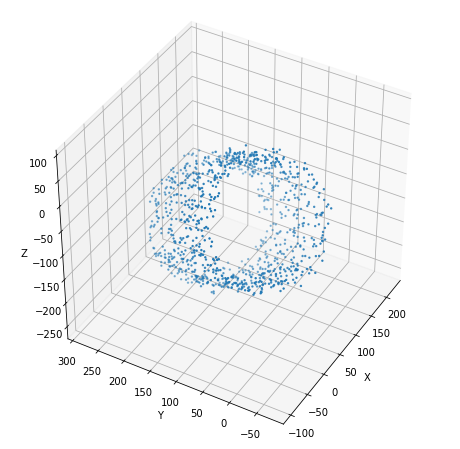

In [5]:
%matplotlib inline
import numpy as np
import skimage.measure as sm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

## test data (1000 points)
X1=np.loadtxt("./dat/cyl.dat")

## make plot
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1[:,0], X1[:,1], X1[:,2], s=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=40, azim=210)
plt.show()


After reading and plotting data we estimate cylinder parameters with RANSAC. In this case `min_samples = 5`. Value of `residual_threshold` is set to `10.0`.

In [7]:
ransac_model, inliers = sm.ransac(X1, CylModel, 5, 10.0)

np.set_printoptions(suppress=True)
print(ransac_model.params)
print("number of points  : ", X1.shape[0])
print("number of outliers: ", X1.shape[0]-np.sum(inliers))

[ 100.6527872169    0.5315482736    0.6334361259   -0.5623300696
  114.4770058482  186.0931126367 -159.2797358391]
number of points  :  1000
number of outliers:  138


We again find that by repeating the above calculation we get slightly different parameters and number of outliers due to the random nature of RANSAC.

Plot consensus set and outliers with another color:

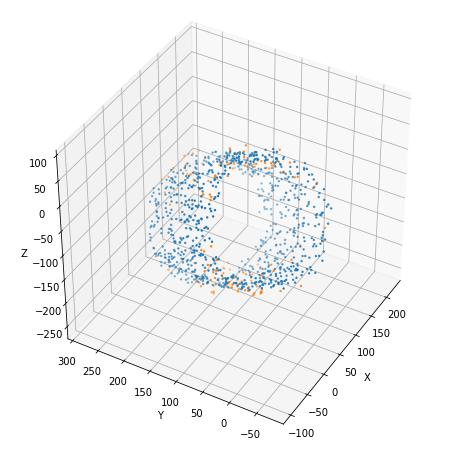

In [8]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1[inliers,0], X1[inliers,1], X1[inliers,2], s=2)
outliers = np.invert(inliers)
ax.scatter(X1[outliers,0], X1[outliers,1], X1[outliers,2], s=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=40, azim=210)
plt.show()

### Fit residuals
Plot histogram of fit residuals

mean : -0.61 %
std  : 13.25 %
max   : 39.27 %


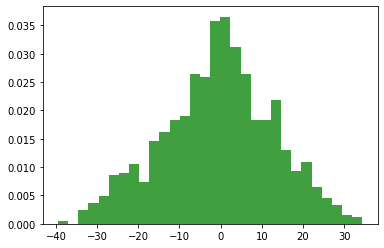

In [9]:
def cyldist(cyl,X,pos=1):
    """
    cyldist(cyl,X) calculates unsigned distances of points in X from cylinder cyl
    cyl: 7-component vector:
         r: radius
         a: unit vector of cylinder axis
         f: position of a point on the cylinder axis
         X: (n,3) matrix of coordinates of n points
         pos: if pos=0, calculate signed, otherwise unsigned distances
    """

    r = cyl[0]
    a = cyl[1:4]
    f = cyl[4:]
    xf = X-f
    ## norm squared
    nxf = xf[:,0]**2+xf[:,1]**2+xf[:,2]**2
    if pos==1:
        dist = np.abs(np.sqrt(nxf - ((X-f).dot(a))**2) - r)
    else:
        dist = np.sqrt(nxf - ((X-f).dot(a))**2) - r
    return dist

# calculate signed distances
v = cyldist(ransac_model.params,X1,0)

# residuals relative to the radius (mean, std)
print( "mean : %.2f %%" % (100*np.mean(v)/ransac_model.params[0]))
print( "std  : %.2f %%" % (100*np.std(v)/ransac_model.params[0]))

# max. percent residual
print( "max   : %.2f %%" % (100*np.max(np.abs((v)))/ransac_model.params[0]))

# histogram of relative residuals
fig = plt.figure()
n, bins, patches = plt.hist(v, 30, density=True, facecolor='green', alpha=0.75)
plt.show()

### Least squares parameter estimation based on RANSAC output

Optimum RANSAC estimation of cylinder parameters was based on elements of the maximal consensus set. As an additional step, this estimation can be refined using elements of this maximal consensus set, for example by least squares. The [procedure](https://www.researchgate.net/profile/Da-chuan_Cheng/publication/221114886_A_Novel_Parameter_Decomposition_Approach_to_Faithful_Fitting_of_Quadric_Surfaces/links/0912f5089d11534155000000.pdf) by Jiang és Cheng can be used for this estimation.

This procedure essentially determines first the direction of the best fitting cylinder's axis, since squared sum of residuals from the superficies of the cylinder remains the same after projecting all points onto a plane perpendicular to the cylinder's axis in a direction that is parallel with the axis. This squared residual sum depends on the axis' direction and is implemented in function `acfit(X,a)`, where array `X` contains an arbitrary number of points in its rows. Direction of the projection is given by two angles: spherical polar distance $\vartheta$ and longitude $\lambda$, which are elements of vector `a`.


In [10]:
from scipy.optimize import minimize

def acfit(X, a, sonly=False):
    ## acfit(X, a, sonly=False) fits a circle to points given as rows of X 
    ##         projected along the direction given by 'a' 
    ## Input:  X: nx3 matrix, [x,y,z] coordinates of n points stored as rows
    ##         a=[theta, lambda]: polar coordinates of projection direction
    ##         sonly: if True, return s only
    ## Output: s, r, c where:
    ##           r: radius of circle
    ##           c=[x0, y0, z0]: center of circle in the projection plane
    ##           s: sum of squared fit residuals

    # projection to a plane passing through the origin
    n=X.shape[0]
    t=a[0]
    l=a[1]
    # unit vector of projection direction
    au = np.array([np.sin(t)*np.cos(l), np.sin(t)*np.sin(l), np.cos(t)])
    # unit vectors in the projection plane
    ath = np.array([np.cos(t)*np.cos(l), np.cos(t)*np.sin(l), -np.sin(t)])
    ala = np.array([-np.sin(l), np.cos(l), 0])
    # coordinates of projected points
    x = np.sum(X*np.tile(ala,(n,1)),axis=1)
    y = np.sum(X*np.tile(ath,(n,1)),axis=1)
    Xs = np.vstack((x,y)).T

    # matrix M
    M=np.hstack((-2*Xs,np.ones((n,1))))
    # vector h
    h=-np.sum(Xs**2,axis=1)
    p,re,ra,ev=np.linalg.lstsq(M,h,rcond=None)
    # radius of sphere
    r=np.sqrt(p[0]**2+p[1]**2-p[2])
    # coordinates of centre in projection plane
    cs=p[0:2]
    # inverse transformed centre in xyz-frame
    TR=np.vstack((ala, ath, au)).T
    c=TR.dot(np.hstack((cs, 0)))
    # squared sum of residuals
    s=np.sum((M.dot(p)-h)**2)
    if sonly:
        return s
    else:
        return s, r, c


To calculate the best fitting cylinder we minimize a one-line function `sqsum` defined with the help of the above defined `acfit` function by using the `minimize` function in module `scipy.optimize`. After axis direction was determined points are projected and other parameters of the best fitting cylinder are calculated. All these steps are implemented in function `cylinder(X)`:

In [11]:
def cylinder(X):
    ## cylinder(X) fits a right circular cylinder into the points stored as rows of X
    ## Input:  X: nx3 matrix, its rows are [x,y,z] coordinates of points
    ## Output: [c, r, a] where:
    ##           r: radius of cylinder
    ##           c=[x0, y0, z0]: position of one point along the cylinder axis
    ##           a=[theta, lambda]: direction of axis (spherical polar coordinates)

    # subtract mean from coordinates
    Xm=np.mean(X,axis=0)
    Xs=X-Xm
    # number of points
    n=X.shape[0]

    # search of minimum
    #
    # one-line cost function to be minimized
    sqsum = lambda x: acfit(X,x,True)
    x0 = np.array([0.1, 0.1])
    res = minimize(sqsum, x0, method='BFGS')
    x = res.x
    # parameters
    a = x
    au = np.array([np.sin(x[0])*np.cos(x[1]), np.sin(x[0])*np.sin(x[1]), np.cos(x[0])])
    print("axis unit vector: [ %.5f,  %.5f,  %.5f ]" % (au[0], au[1], au[2]))
    # unit vectors in the projection plane
    ath = np.array([np.cos(x[0])*np.cos(x[1]), np.cos(x[0])*np.sin(x[1]), -np.sin(x[0])])
    ala = np.array([-np.sin(x[1]), np.cos(x[1]), 0])
    # coordinates of projected points
    x = np.sum(X*np.tile(ala,(n,1)),axis=1)
    y = np.sum(X*np.tile(ath,(n,1)),axis=1)
    # other parameters:
    s, r, c = acfit(Xs, a)
    c = c + Xm
    return c, r, a


Elements of the consensus set are in `X1[inliers,:]`. These are used in least squares estimation of parameters of the best fitting cylinder.

In [12]:
c, r, a = cylinder(X1[inliers,:])
print("point on the axis : ", c)
print("radius            : ", r)

axis unit vector: [ -0.42194,  -0.69629,  0.58065 ]
point on the axis :  [ 66.8591081647 108.0224500592 -90.4356440426]
radius            :  100.26781589054922


Our previous values were these:

    [ 100.6527872169    0.5315482736    0.6334361259   -0.5623300696
      114.4770058482  186.0931126367 -159.2797358391]

It can be seen that radius is slightly different and axis unit vector is in the opposite direction.